**Data loading and model architecture are based on the tutorial <https://cv.gluon.ai/build/examples_action_recognition/finetune_custom.html>**

TEST WHEN GPU IS AVAILABLE AGAIN

In [1]:
SAVE_VALIDATION_VIDEOS = True
filestem = 'model_saves_3/'
AUTOSAVE_FREQUENCY = 10
EPOCHS = 1

INITIAL_LEARNING_RATE = 0
# INITIAL_LEARNING_RATE = 0.001

In [2]:
from __future__ import division

import argparse, time, logging, os, sys, math

import numpy as np
import mxnet as mx
import gluoncv as gcv
from mxnet import gluon, nd, init, context
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data.transforms import video
from gluoncv.data import VideoClsCustom
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRSequential, LRScheduler, split_and_load, TrainingHistory

import imageio

**Functions `pickle_stuff()` and `unpickle_stuff()` are used to save and load everything important about the model and its training.** <br> Note that even though the names say 'pickle', not all of the files are actually '.pkl' format; I'm using 'pickle' in its more general sense as 'preserve'.  Thanks to <https://mxnet.apache.org/versions/1.9.1/api/python/docs/tutorials/packages/gluon/blocks/save_load_params.html> for assistance.

In [3]:
import pickle

def pickle_stuff():
    with open(filestem + 'preserved_history.pkl', 'wb') as pkl_file:
        pickle.dump(train_history, pkl_file)
    with open(filestem + 'preserved_epoch_count.pkl', 'wb') as pkl_file:
        pickle.dump(total_epochs, pkl_file)
    net.save_parameters(f'{filestem}preserved_params_{total_epochs:04d}.params')

def unpickle_stuff():
    global train_history, total_epochs, net
    with open(filestem + 'preserved_history.pkl', 'rb') as pkl_file:
        train_history = pickle.load(pkl_file)
    with open(filestem + 'preserved_epoch_count.pkl', 'rb') as pkl_file:
        total_epochs = pickle.load(pkl_file)
    net.load_parameters(f'{filestem}preserved_params_{total_epochs:04d}.params', ctx=ctx)

In [4]:
def predict_classes(prob_array):
    prob_array = nd.squeeze(prob_array)
    return nd.argsort(prob_array, dtype='int64')[::-1]

**We now return to our regularly-scheduled tutorial 7.**

In [5]:
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

transform_train = video.VideoGroupTrainTransform(size=(224, 224), scale_ratios=[1.0, 0.8], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform_val = video.VideoGroupValTransform(size=(224, 224), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

per_device_batch_size = 5
num_workers = 0
batch_size = per_device_batch_size * num_gpus

Interesting fact: there is actually a certain amount of data augmentation coming from the tutorial.  Here's another article that might (or might not) be useful: <https://mxnet.apache.org/versions/1.9.1/api/python/docs/tutorials/packages/gluon/data/data_augmentation.html>

In [6]:
train_dataset = VideoClsCustom(root='',
                               setting='train_100_med.txt',
                               train=True,
                               new_length=32,
                               transform=transform_train,
                               video_loader=True,
                               video_ext='.mp4'
                              )
print('Load %d training samples.' % len(train_dataset))
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)

val_dataset = VideoClsCustom(root='',
                               setting='val_100_med.txt',
                               train=False,
                               new_length=32,
                               transform=transform_val,
                               video_loader=True,
                               video_ext='.mp4'
                              )
print('Load %d validation samples.' % len(val_dataset))
val_data = gluon.data.DataLoader(val_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)

Load 3036 training samples.
Load 911 validation samples.


**TODO** Try to add dropout in the last layers, as a regularization technique.
(Printing the model reveals one of them already has a dropout of 0.8, which could be modified.)

In [7]:
net = get_model(name='i3d_resnet50_v1_custom', nclass=100)
net.collect_params().reset_ctx(ctx)

conv0_weight is done with shape:  (64, 3, 5, 7, 7)
batchnorm0_gamma is done with shape:  (64,)
batchnorm0_beta is done with shape:  (64,)
batchnorm0_running_mean is done with shape:  (64,)
batchnorm0_running_var is done with shape:  (64,)
layer1_0_conv0_weight is done with shape:  (64, 64, 3, 1, 1)
layer1_0_batchnorm0_gamma is done with shape:  (64,)
layer1_0_batchnorm0_beta is done with shape:  (64,)
layer1_0_batchnorm0_running_mean is done with shape:  (64,)
layer1_0_batchnorm0_running_var is done with shape:  (64,)
layer1_0_conv1_weight is done with shape:  (64, 64, 1, 3, 3)
layer1_0_batchnorm1_gamma is done with shape:  (64,)
layer1_0_batchnorm1_beta is done with shape:  (64,)
layer1_0_batchnorm1_running_mean is done with shape:  (64,)
layer1_0_batchnorm1_running_var is done with shape:  (64,)
layer1_0_conv2_weight is done with shape:  (256, 64, 1, 1, 1)
layer1_0_batchnorm2_gamma is done with shape:  (256,)
layer1_0_batchnorm2_beta is done with shape:  (256,)
layer1_0_batchnorm2_ru

**Here's a cell I set to `raw` rather than `code` to prevent it from executing because we do *not* need that much visual clutter most of the time.**

In [8]:
# Learning rate decay factor
lr_decay = 0.4
# Epochs where learning rate decays
# lr_decay_epoch = [40, 80, 100]
lr_decay_epoch = [15, 40, 80, 300, 1000]

# Stochastic gradient descent
optimizer = 'sgd'
# Set parameters
optimizer_params = {'learning_rate': INITIAL_LEARNING_RATE, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

In [9]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

In [10]:
train_metric, val_metric = mx.metric.Accuracy(), mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc', 'validation-acc'])

In [11]:
# Keeps track of how many epochs the model has been training for, total, not just in this session.
total_epochs = 0

**We have now set up everything we would need to run from the start, but it is better to try to load the progress we have made so far.**

In [12]:
try:
    unpickle_stuff()
except FileNotFoundError:
    print('''Couldn't find at least one file on this list:
    preserved_epoch_count.pkl
    preserved_history.pkl
    preserved_params_{epoch_count}.params
This may cause unintended behavior.
Deleting all of these files will force a total reset.''')

**This cell is the cell that actually runs training.  Run it as many times, with as many `epochs` as you wish.**  Thanks to <https://mxnet.apache.org/versions/1.9.1/api/python/docs/tutorials/packages/gluon/data/datasets.html> for help adding a validation loop.  **NOTE:** Rerunning this cell resets the learning rate decay.  Scroll up to just below the cell that says **Here's a cell I set to `raw`** and modify the learning rate decay if desired.

`autosave_frequency` (now defined at the top as `AUTOSAVE_FREQUENCY`) controls the frequency of several things:

- How often it runs a validation loop (because it doesn't need to do this every time; that's a waste of time)
- How often it preserves the leftovers (because a file of saved parameters for EVERY SINGLE EPOCH is a bit much)
- How often it prints out a graph (doing so for every epoch would just be cluttered).


[21:38:13] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


[Epoch 401] train=0.904950 val=0.601980 loss=0.486151 time: 290.743215


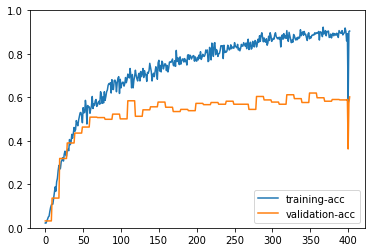

In [13]:
epochs = EPOCHS
lr_decay_count = 0

autosave_frequency = AUTOSAVE_FREQUENCY

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = []
            for _, X in enumerate(data):
                X = X.reshape((-1,) + X.shape[2:])
                pred = net(X)
                output.append(pred)
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.mean().asscalar() for l in loss])
        train_metric.update(label, output)

        if i == 100:
            break
    
    if epoch == 0 or (total_epochs % autosave_frequency == autosave_frequency - 1):
        val_metric.reset()
        
        # Loop through each batch of validation data
        for i, batch in enumerate(val_data):
            # Extract data and label
            data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
            label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

            # The autograd prediction / loss calculation, except without the autograd
            output = []
            for _, X in enumerate(data):
                X = X.reshape((-1,) + X.shape[2:])
                pred = net(X)
                output.append(pred)
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]
            
            if SAVE_VALIDATION_VIDEOS:
                data_u = data[0]

                # Save videos
                for j in range(label[0].shape[0]):
                    # Video is at data[j, 0]??
                    vid_data = data_u[j, 0].asnumpy()
                   # vid_data = vid_data.reshape((32, 224, 224, 3))
                    vid_data_2 = np.zeros((32, 224, 224, 3), dtype=np.float32)
                    vid_data_2[:,:,:,0] = vid_data[0]
                    vid_data_2[:,:,:,1] = vid_data[1]
                    vid_data_2[:,:,:,2] = vid_data[2]
                    vid_data = np.interp(vid_data_2, (vid_data_2.min(), vid_data_2.max()), (0, 255)).astype(np.uint8)
                    
                    concrete_pred = predict_classes(output[0][j])
                    if not label[0][j] == concrete_pred[0]:
                        imageio.mimwrite(f'videodir/validation_feedback/{filestem}fail_{total_epochs}_{i}_{j}.mp4', vid_data, fps=15, macro_block_size=16)
                        with open(f'videodir/validation_feedback/{filestem}_list.txt', 'a') as file:
                            file.write(f"FAIL: Video {total_epochs}_{i}_{j} has label {label[0][j].asscalar()}, predicted top 5 {concrete_pred[:5]}.")
                    else:
                        imageio.mimwrite(f'videodir/validation_feedback/{filestem}succ_{total_epochs}_{i}_{j}.mp4', vid_data, fps=15, macro_block_size=16)
                        with open(f'videodir/validation_feedback/{filestem}_list.txt', 'a') as file:
                            file.write(f"SUCCESS: Video {total_epochs}_{i}_{j} has label {label[0][j].asscalar()}, predicted top 5 {concrete_pred[:5]}.")
            
            # Update metrics
            val_metric.update(label, output)

            if i == 100:
                break

    train_name, train_acc = train_metric.get()
    val_name, val_acc = val_metric.get()

    # Update history and print metrics
    train_history.update([train_acc, val_acc])
    
    print('[Epoch %d] train=%f val=%f loss=%f time: %f' %
        (total_epochs, train_acc, val_acc, train_loss / (i+1), time.time()-tic))
    
    total_epochs += 1
    if epoch == 0 or total_epochs % autosave_frequency == 0:
        pickle_stuff()
        train_history.plot(legend_loc='lower right')

**Debrief: save any progress since the last autosave and print out the latest information.**

In [14]:
pickle_stuff()

In [15]:
print('[Epoch %d] train=%f val=%f loss=%f' %
        (total_epochs, train_acc, val_acc, train_loss / (i+1)))

[Epoch 402] train=0.904950 val=0.601980 loss=0.486151


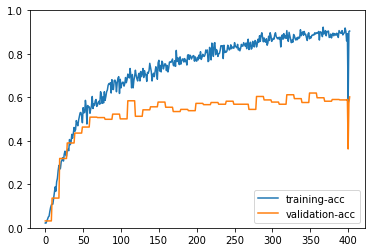

In [16]:
train_history.plot(legend_loc='lower right')